In [61]:
from timeit import default_timer as timer
import numpy as np
import pandas as pd
from math import isnan
from sklearn import preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from loguru import logger
import warnings
warnings.filterwarnings('ignore')

class PreProcessor:
    def __init__(self):
        self.unique_count = 1
    
    def RemoveIrrelevantColumn(self,df):
        count=0
        for column in df.columns:
            if df[column].nunique(dropna=True)==self.unique_count:
                print(f'Column :{column} is removed')
                count=count+1
                df=df.drop(column,axis=1)
        print(f'{count} irrelavant columns found.')
        return df

        

    def HandlingMissingData(self,df,num_strategy='most_frequent',cat_strategy='knn',n_neighbors=3,null_threshold=0.1):
        num_cols = df.select_dtypes(include=np.number).columns
        cat_cols = [column for column in df.columns if column not in num_cols]
        
        for column in num_cols:
            null_val=df[column].isnull().mean()
            if(null_val!=0 and null_val<=null_threshold):
                print(f'{null_val}% NaN values found on column: {column}')
                df=df.dropna(subset=[column])
                df= df.reset_index(drop=True)

        imputer=None
        if(num_strategy=='knn'):
            imputer = KNNImputer(n_neighbors=n_neighbors)
        else:
            if num_strategy in ['mean','median','mode','most_frequent']:
                imputer = SimpleImputer(strategy=num_strategy)
            else:
                print('Invalid imputer strategy specified :{}\nDefault strategy Mean is applied',num_strategy)
                imputer = SimpleImputer(strategy='mean')
        print('imputation process started...')
        for feature in num_cols:
            if df[feature].isna().sum().sum() != 0:
                try:
                    df_imputed = pd.DataFrame(imputer.fit_transform(np.array(df[feature]).reshape(-1, 1)))
                    if (df[feature].fillna(-9999) % 1  == 0).all():
                        df[feature] = df_imputed
                        # round back to INTs, if original data were INTs
                        df[feature] = df[feature].round()
                        df[feature] = df[feature].astype('Int64')                                        
                    else:
                        df[feature] = df_imputed
                except:
                    print('imputation failed for feature "{}"',feature)
        if(cat_strategy=='knn'):
            imputer = KNNImputer(n_neighbors=n_neighbors)
        elif(cat_strategy=='logreq'):
            df = PreProcessor.LogisticRegressionImputer(
                columns=cat_cols,
                df=df
            )
            return df
        else:
            imputer = SimpleImputer(strategy='most_frequent')
        
        for feature in cat_cols:
            if df[feature].isna().sum()!= 0:
                try:
                    mapping = dict()
                    mappings = {k: i for i, k in enumerate(df[feature].dropna().unique(), 0)}
                    mapping[feature] = mappings
                    df[feature] = df[feature].map(mapping[feature])

                    df_imputed = pd.DataFrame(imputer.fit_transform(np.array(df[feature]).reshape(-1, 1)), columns=[feature])    

                    # round to integers before mapping back to original values
                    df[feature] = df_imputed
                    df[feature] = df[feature].round()
                    df[feature] = df[feature].astype('Int64')  

                    # map values back to original
                    mappings_inv = {v: k for k, v in mapping[feature].items()}
                    df[feature] = df[feature].map(mappings_inv)
                except:
                    print('Imputation failed for feature "{}"',  feature)
        return df
    
    
    def normalization(self,df):
        sc = StandardScaler()
        normalize_columns = []
        for column in df.columns:
            if (df[column].dtype == 'int64' or df[column].dtype == 'float64') and df[column].nunique() > 10:
                normalize_columns.append(column)
        df[normalize_columns] = sc.fit_transform(df[normalize_columns])
        # Is normalization Done well
        normalized_feature = df[normalize_columns]
        mean_normalized = np.mean(normalized_feature)
        std_dev_normalized = np.std(normalized_feature)
        print("Mean of normalized feature:", mean_normalized)
        print("Standard deviation of normalized feature:", std_dev_normalized)
        return df
    
    
    
    
    def encoding(self,df):   
        lable_encoder = preprocessing.LabelEncoder()
        object_columns = []
        for column in df.columns:
                if df[column].dtype == 'object' and df[column].nunique()<3: #binary 
                    df[column]=lable_encoder.fit_transform(df[column])
                    object_columns.append(column)
                elif df[column].dtype == 'object' and (df[column].nunique()>2): #Multi-class 
                    df[column]=lable_encoder.fit_transform(df[column])
                    object_columns.append(column)
                elif df[column].dtype == 'bool':
                    df[column]=lable_encoder.fit_transform(df[column])
                    object_columns.append(column)
                else:
                    pass
        return df,object_columns
    
    
    
        
    def LogisticRegressionImputer(self,columns,df):
             for feature in columns:
                 try:
                     test_df = df[df[feature].isnull()==True].dropna(subset=[x for x in df.columns if x != feature])
                     train_df = df[df[feature].isnull()==False].dropna(subset=[x for x in df.columns if x != feature])
                     if len(test_df.index) != 0:
                         pipe = make_pipeline(StandardScaler(), LogisticRegression())  
                         y = train_df[feature]
                         train_df.drop(feature, axis=1, inplace=True)
                         test_df.drop(feature, axis=1, inplace=True)   
                         model = pipe.fit(train_df, y)
                       
                         pred = model.predict(test_df) # predict values
                         test_df[feature]= pred
                         if (df[feature].fillna(-9999) % 1  == 0).all():
                             # round back to INTs, if original data were INTs
                             test_df[feature] = test_df[feature].round()
                             test_df[feature] = test_df[feature].astype('Int64')
                             df[feature].update(test_df[feature])                             
                         print('LOGREG imputation of {} value(s) succeeded for feature "{}"', len(pred), feature)
                 except:
                     print('LOGREG imputation failed for feature "{}"', feature)
                 for feature in df.columns: 
                     try:
                         # map categorical feature values back to original
                         mappings_inv = {v: k for k, v in mapping[feature].items()}
                         df[feature] = df[feature].map(mappings_inv)
                     except:
                         pass     
             return df
    

In [62]:
data=pd.read_csv('./Dataset/titanic_data.csv')
data


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
885,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
886,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
887,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [63]:
clean=PreProcessor()
data=clean.RemoveIrrelevantColumn(data)
data=clean.HandlingMissingData(data)
data,objects_columns=clean.encoding(data)
objects_columns


0 irrelavant columns found.
imputation process started...


['sex',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alive',
 'alone']

# Constant Variance Check

In [64]:
print(objects_columns)

['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']


In [65]:
def constant_variance(data):
    print("Finding Constant Variance Columns...")
    constant_columns = []
    from sklearn.feature_selection import VarianceThreshold
    var_thres=VarianceThreshold(threshold=0)
    var_thres.fit(data)
    constant_columns = [column for column in data.columns
                    if column not in data.columns[var_thres.get_support()]]
    print(len(constant_columns))
    if constant_columns:
     for column in constant_columns:
         print(f'Total {len(constant_columns)} are being removed and the Columns are: {column}')
     data=data.drop(columns=constant_columns)
    else:
        print("No constant variance columns found.")
    return data

# Splitting the data into train and test    

In [66]:

def data_splitting(data, dependent_variable):
    print("Splitting of dataset into train and test...")
    from sklearn.model_selection import train_test_split
    X = data.drop(dependent_variable, axis=1)
    y = data[dependent_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    result_dict = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
     

    return result_dict


# Highly Correlated Feature Removal

In [68]:
def corr_drop(data,dependent_variable):
    result=data_splitting(data,dependent_variable)  # Data Splitting
    X_train=result['X_train']
    X_test=result['X_test']
    print(X_train)
    y_train=result['y_train']
    y_test=result['y_test']      
    import seaborn as sns
    import matplotlib.pyplot as plt 
    import pandas as pd
    #Using Pearson Correlation
    plt.figure(figsize=(12,10))
    cor = X_train.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
    plt.show()
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = X_train.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i): # lower triangle of an matrix
            if (corr_matrix.iloc[i, j]) > 0.80: # we are interested in coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    print(f'Total {len(col_corr)} are being removed and the Columns are: {col_corr}')
    print(X_train)
    X_train=X_train.drop(col_corr,axis=1)
    X_test=X_test.drop(col_corr,axis=1)
    print(X_train.columns)
    
    return X_train,X_test,y_train,y_test

Splitting of dataset into train and test...
(622, 14) (267, 14) (622,) (267,)
     pclass  sex   age  sibsp  parch      fare  embarked  class  who  \
350       1    1  24.0      0      0   35.0000         2      0    1   
124       1    1  54.0      0      1   77.2875         2      0    1   
577       3    0  24.0      1      0   14.4583         0      2    2   
422       3    0  28.0      1      1   14.4000         2      2    2   
118       1    1  24.0      0      1  247.5208         0      0    1   
..      ...  ...   ...    ...    ...       ...       ...    ...  ...   
835       3    1  24.0      0      0    8.0500         2      2    1   
192       3    0  19.0      1      0    7.8542         2      2    2   
629       3    1  51.0      0      0    7.0542         2      2    1   
559       3    1  24.0      0      0    7.7500         1      2    1   
684       3    1  14.0      4      1   39.6875         2      2    0   

     adult_male  deck  embark_town  alive  alone  
350   

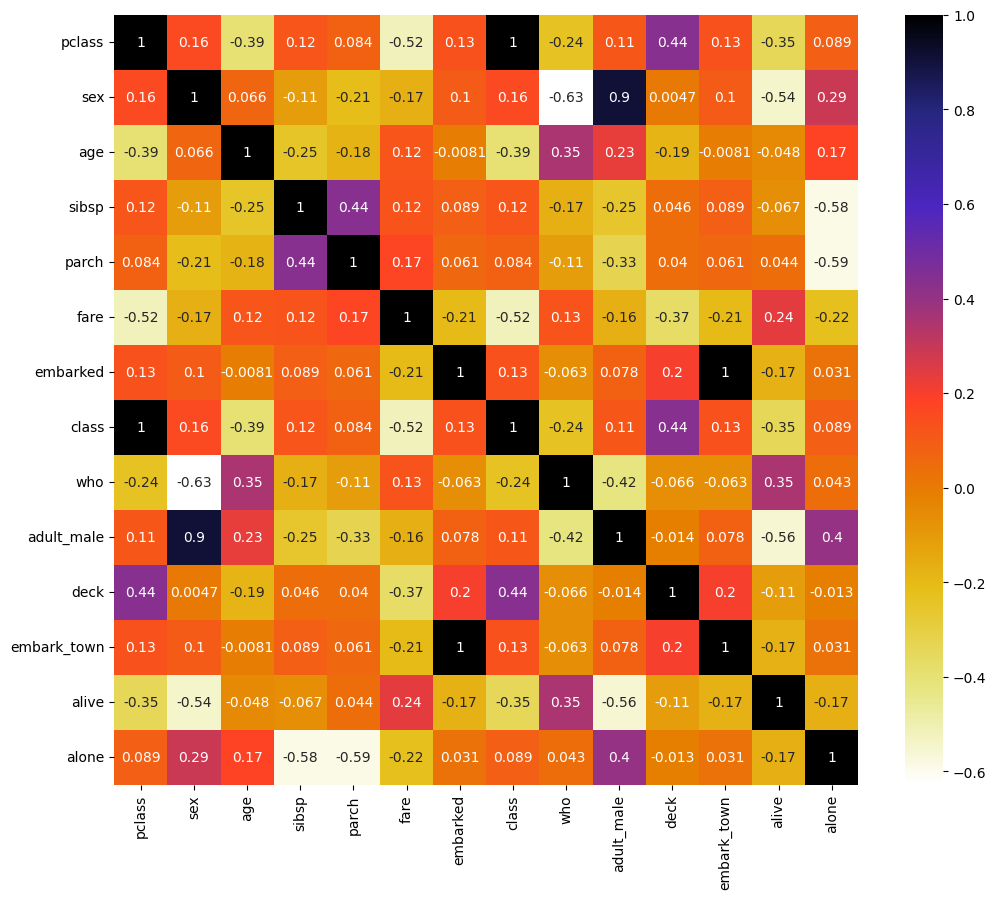

Total 3 are being removed and the Columns are: {'adult_male', 'embark_town', 'class'}
     pclass  sex   age  sibsp  parch      fare  embarked  class  who  \
350       1    1  24.0      0      0   35.0000         2      0    1   
124       1    1  54.0      0      1   77.2875         2      0    1   
577       3    0  24.0      1      0   14.4583         0      2    2   
422       3    0  28.0      1      1   14.4000         2      2    2   
118       1    1  24.0      0      1  247.5208         0      0    1   
..      ...  ...   ...    ...    ...       ...       ...    ...  ...   
835       3    1  24.0      0      0    8.0500         2      2    1   
192       3    0  19.0      1      0    7.8542         2      2    2   
629       3    1  51.0      0      0    7.0542         2      2    1   
559       3    1  24.0      0      0    7.7500         1      2    1   
684       3    1  14.0      4      1   39.6875         2      2    0   

     adult_male  deck  embark_town  alive  alone 

(     pclass  sex   age  sibsp  parch      fare  embarked  who  deck  alive  \
 350       1    1  24.0      0      0   35.0000         2    1     2      0   
 124       1    1  54.0      0      1   77.2875         2    1     3      0   
 577       3    0  24.0      1      0   14.4583         0    2     3      0   
 422       3    0  28.0      1      1   14.4000         2    2     3      0   
 118       1    1  24.0      0      1  247.5208         0    1     1      0   
 ..      ...  ...   ...    ...    ...       ...       ...  ...   ...    ...   
 835       3    1  24.0      0      0    8.0500         2    1     3      0   
 192       3    0  19.0      1      0    7.8542         2    2     3      1   
 629       3    1  51.0      0      0    7.0542         2    1     3      0   
 559       3    1  24.0      0      0    7.7500         1    1     3      0   
 684       3    1  14.0      4      1   39.6875         2    0     3      0   
 
      alone  
 350      1  
 124      0  
 577    

In [69]:
corr_drop(data,'survived')

# CHI-SQUARE TEST

In [94]:
def chi2(data,dependent_variable,objects_columns):
    result=data_splitting(data,dependent_variable)  # Data Splitting
    X_train=result['X_train']
    y_train=result['y_train']
    X_train_objects = X_train[objects_columns]
    from sklearn.feature_selection import chi2
    f_p_values = chi2(X_train_objects, y_train)
    p_value = pd.Series(f_p_values[1])
    f_value=pd.Series(f_p_values[0])
    p_value.index=X_train_objects.columns
    f_value.index=X_train_objects.columns
        
    
        
    return p_value,f_value
        
    
    
 

In [96]:
p_value,f_value=chi2(data,'survived',objects_columns)

Splitting of dataset into train and test...
(622, 14) (267, 14) (622,) (267,)


In [97]:
p_value.sort_values(ascending=True)

alive       6.147428e-86
sex         1.437418e-15
who         1.639330e-06
embarked    7.214559e-03
alone       8.656477e-03
deck        2.195293e-01
dtype: float64

In [100]:
f_value.sort_values(ascending=False)

alive       386.000000
sex          63.715600
who          22.977213
embarked      7.218758
alone         6.892363
deck          1.507445
dtype: float64

In [ ]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
X=data.drop('Price',axis=1)
y=data['Price']

KeyError: "['Price'] not found in axis"

In [ ]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

In [ ]:
X_train.corr()

In [ ]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(X_train, 0.6)
len(set(corr_features))

In [ ]:
corr_features

In [ ]:
X_train.drop(corr_features,axis=1)
X_test.drop(corr_features,axis=1)